In [1]:
%matplotlib inline
import openmc
import openmc.model
import openmc.deplete
import math
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Defining Materials

# FUEL
uo2 = openmc.Material(1, name = "Fuel_1")
uo2.add_element('U', 1, enrichment = 5)
uo2.add_element('O', 2)

puo2 = openmc.Material (2, name = 'Fuel_2')
puo2.add_nuclide ('Pu239', 1)
puo2.add_element ('O', 2)

#MODERATOR

h2o = openmc.Material(3, name = "Moderator")
h2o.add_element('H', 2)
h2o.add_element('O', 1)
h2o.set_density('g/cm3', 1.0)
h2o.add_s_alpha_beta('c_H_in_H2O') #Considers scattering of moderator

#CLADDING

zr = openmc.Material(4, name = "Clad_Material")
zr.add_element('Zr', 1)
zr.set_density('g/cm3', 6.5)

#GAP

he = openmc.Material (5, name = 'Gap')
he.add_element ('He', 1)
he.set_density ('g/cm3', 0.00016)

#MOX FUEL

mox = openmc.Material.mix_materials([uo2, puo2], [0.8, 0.2], 'wo')
mox.set_density ('g/cm3', 11)

materials = openmc.Materials([mox, h2o, zr, he])
print(materials)

[Material
	ID             =	6
	Name           =	Fuel_1(0.8)-Fuel_2(0.2)
	Temperature    =	None
	Density        =	11 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	0.00012072443908431328 [ao]
	U235           =	0.013506661190402142 [ao]
	U238           =	0.25320503334669725 [ao]
	U236           =	6.186699571755585e-05 [ao]
	O16            =	0.6650803999999999 [ao]
	O17            =	0.0002526666666666666 [ao]
	O18            =	0.0013335999999999997 [ao]
	Pu239          =	0.06643904736143205 [ao]
, Material
	ID             =	3
	Name           =	Moderator
	Temperature    =	None
	Density        =	1.0 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O16            =	0.9976206    [ao]
	O17            =	0.000379     [ao]
	O18            =	0.0020004    [ao]
, Material
	ID    

In [3]:
materials.export_to_xml ()

In [4]:
#Defining Geometrical Shapes

hole = openmc.ZCylinder (r = 0.5)
fuel_or = openmc.ZCylinder(r = 2)
clad_ir = openmc.ZCylinder(r = 2.2)
clad_or = openmc.ZCylinder(r = 2.5)
rect = openmc.model.rectangular_prism (6, 6, axis='z', origin=(0., 0.), boundary_type='reflective')

/opt/conda/lib/python3.11/site-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


In [5]:
# Defining Fuel Region Geometry

hole_region = -hole
fuel_region = +hole & -fuel_or
gap_region = +fuel_or & -clad_ir
clad_region = +clad_ir & -clad_or
mod_region = rect & +clad_or

In [6]:
#Defining Cells

#Hole

hole_cell = openmc.Cell()
hole_cell.fill = he
hole_cell.region = hole_region

#Fuel Cell
fuel_cell = openmc.Cell()
fuel_cell.fill = mox
fuel_cell.region = fuel_region

#Gap
gap_cell = openmc.Cell()
gap_cell.fill = he
gap_cell.region = gap_region

#Cladding
clad_cell = openmc.Cell()
clad_cell.fill = zr
clad_cell.region = clad_region

#Moderator
mod_cell = openmc.Cell()
mod_cell.fill = h2o
mod_cell.region = mod_region

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

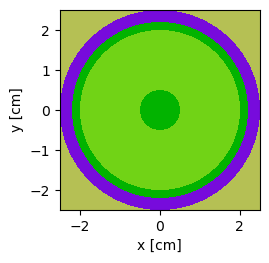

In [7]:
root = openmc.Universe(cells = (hole_cell, fuel_cell, gap_cell, clad_cell, mod_cell))
root.plot (width = (5,5), basis = 'xy', color_by = 'material')

In [8]:
geom = openmc.Geometry(root)
geom.export_to_xml()

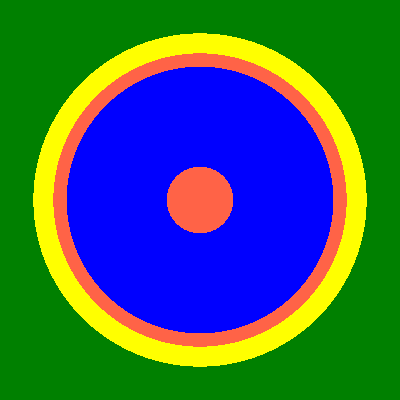

In [9]:
p = openmc.Plot()
p.filename = 'Class 3_202128029'
p.width = (6.0,6.0)
p.pixel = (3000,3000)
p.color_by = 'material'
p.colors = {mox: 'blue', zr: 'yellow', h2o: 'green', he: 'tomato'}
openmc.plot_inline(p)

In [10]:
settings = openmc.Settings()
settings.batches = 200      #Generation number
settings.inactive = 20      #First 20 batch of generation will not be counted due to fluctuation of values
settings.particles = 1000   #Initial particle number
settings.export_to_xml()
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [11]:
uo2.volume = math.pi*(0.39**2) 

In [12]:
chain = openmc.deplete.Chain.from_xml

In [13]:
model = openmc.Model (geometry = geom, settings = settings, materials = materials)
operator = openmc.deplete.CoupledOperator

In [16]:
power = 110
bu_steps = np.array ([0.2, 0.4, 0.6, 1.1, 1.6, 2.6, 3.6, 4.6])
burnup = np.diff (bu_steps, prepend = 0.0)
timesteps = [30]*6

In [18]:
integrator = openmc.deplete.PredictorIntegrator(operator, burnup, timesteps, power, timestep_units = 'MWd/kg')

AttributeError: type object 'CoupledOperator' has no attribute 'prev_res'

In [ ]:
integrator.integrate ()